In this tutorial, we extend the electricity-only model considered in Tutorial 2 by considering a multisector model for joint capacity expansion in electricity and hydrogen sectors. 

To do this, we scorporate hydrogen and electricity demand from Tutorial 2, and endogeneously model hydrogen production and storage in MACRO.

First, we create a new case folder named "one_zone_multisector"

In [111]:
# Activate the environment using the path to the Macro repository
macro_repo_path = dirname(@__DIR__)
using Pkg; Pkg.activate(macro_repo_path)

  Activating project at `~/Code/Macro`


In [112]:
using Macro
using HiGHS
using CSV
using DataFrames
using JSON3
using Plots
using VegaLite

In [113]:
if !isdir("one_zone_multisector")
    mkdir("one_zone_multisector")
    cp("one_zone_electricity_only/assets","one_zone_multisector/assets", force=true)
    cp("one_zone_electricity_only/settings","one_zone_multisector/settings", force=true)
    cp("one_zone_electricity_only/system","one_zone_multisector/system", force=true)
    cp("one_zone_electricity_only/system_data.json","one_zone_multisector/system_data.json", force=true)
end


We add Hydrogen to the list of modeled commodities, modifying file `system/commodities.json`:

In [114]:
new_macro_commodities = Dict("commodities"=> ["Electricity", "NaturalGas", "CO2","Hydrogen"])

open("one_zone_multisector/system/commodities.json", "w") do io
    JSON3.pretty(io, new_macro_commodities)
end


Update file `system/time_data.json` accordingly:

In [115]:
new_time_data = Dict("PeriodLength"=>8760,
                    "HoursPerTimeStep"=>Dict("Electricity"=>1,"NaturalGas"=> 1,"CO2"=> 1,"Hydrogen"=>1),
                    "HoursPerSubperiod"=>Dict("Electricity"=>8760,"NaturalGas"=> 8760,"CO2"=> 8760,"Hydrogen"=>8760)
                )

open("one_zone_multisector/system/time_data.json", "w") do io
    JSON3.pretty(io, new_time_data)
end

Move separate electricity and hydrogen demand timeseries into the system folder

In [116]:
cp("demand_timeseries/electricity_demand.csv","one_zone_multisector/system/demand.csv";force=true)

"one_zone_multisector/system/demand.csv"

In [117]:
cp("demand_timeseries/hydrogen_demand.csv","one_zone_multisector/system/hydrogen_demand.csv";force=true)

"one_zone_multisector/system/hydrogen_demand.csv"

**Task 1:** using the existing electricity nodes in `system/nodes.json` as template, add an Hydrogen demand node, linking it to the `hydogen_demand.csv` timeseries.

Next, we add an electrolyzer asset represented in Macro as a transformation connecting electricity and hydrogen nodes:

![electrolyzer](images/electrolyzer_asset.png)

To include the electrolyzer, create a file `assets/electrolyzer.json` that looks like this:

```json
{
   "electrolyzer": [
        {   
            "type": "Electrolyzer",
            "global_data":{
                "nodes": {},
                "transforms": {
                    "timedata": "Electricity",
                    "constraints": {
                            "BalanceConstraint": true
                    }
                },
                "edges": {
                    "h2_edge": {
                        "type": "Hydrogen",
                        "unidirectional": true,
                        "has_capacity": true,
                        "can_retire": true,
                        "can_expand": true,
                        "constraints": {
                                "CapacityConstraint": true,
                                "RampingLimitConstraint": true,
                                "MinFlowConstraint": true
                            }
                    },
                    "elec_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "has_capacity": false
                    }
                }
            },
            "instance_data":[
                {
                    "id": "SE_Electrolyzer",
                    "transforms":{
                        "efficiency_rate": 0.875111139
                    },
                    "edges":{
                            "elec_edge": {
                                "start_vertex": "elec_SE"
                            },
                            "h2_edge": {
                                "end_vertex": "h2_SE",
                                "existing_capacity": 0,
                                "investment_cost": 41112.53426,
                                "fixed_om_cost": 1052.480877,
                                "variable_om_cost": 0.0,
                                "capacity_size": 1.5752,
                                "ramp_up_fraction": 1,
                                "ramp_down_fraction": 1,
                                "min_flow_fraction":0.1
                            }
                    }
                }
            ]

        }
    ]
}
```

We also include an hydrogen storage resource cluster, represented in MACRO as combination of a compressor transformation (consuming electricity to compress the gas) and a storage node:

![hydrogen_storage](images/hydrogen_storage.png)

Add a file `assets/h2_storage.json` that should look like:

```json
{
    "h2stor": [
        {
            "type": "GasStorage",
            "global_data": {
                "nodes": {},
                "transforms": {
                    "timedata": "Hydrogen",
                    "constraints": {
                        "BalanceConstraint": true
                    }
                },
                "edges": {
                    "discharge_edge": {
                        "type": "Hydrogen",
                        "unidirectional": true,
                        "can_expand": true,
                        "can_retire": false,
                        "has_capacity": true,
                        "constraints": {
                            "CapacityConstraint": true,
                            "RampingLimitConstraint": true
                        }
                    },
                    "charge_edge": {
                        "type": "Hydrogen",
                        "unidirectional": true,
                        "has_capacity": true,
                        "can_expand": true,
                        "can_retire": false,
                        "constraints": {
                            "CapacityConstraint": true
                        }
                    },
                    "compressor_elec_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "has_capacity": false
                    },
                    "compressor_gas_edge": {
                        "type": "Hydrogen",
                        "unidirectional": true,
                        "has_capacity": false
                    }
                },
                "storage": {
                    "commodity": "Hydrogen",
                    "can_expand": true,
                    "can_retire": false,
                    "constraints": {
                        "StorageCapacityConstraint": true,
                        "BalanceConstraint": true,
                        "MinStorageLevelConstraint": true
                    }
                }
            },
            "instance_data": [
                {
                    "id": "SE_Above_ground_storage",
                    "transforms": {
                        "electricity_consumption": 0.018029457
                    },
                    "edges": {
                        "discharge_edge": {
                            "end_vertex": "h2_SE",
                            "existing_capacity": 0,
                            "investment_cost": 0.0,
                            "fixed_om_cost": 0.0,
                            "variable_om_cost": 0.0,
                            "efficiency": 1.0,
                            "ramp_up_fraction": 1,
                            "ramp_down_fraction": 1
                        },
                        "charge_edge":{
                            "existing_capacity": 0,
                            "investment_cost": 3219.236569,
                            "fixed_om_cost": 0.0,
                            "variable_om_cost": 0.0,
                            "efficiency": 1.0
                        },
                        "compressor_gas_edge": {
                            "start_vertex": "h2_SE"
                        },
                        "compressor_elec_edge": {
                            "start_vertex": "elec_SE"
                        }
                    },
                    "storage":{
                        "investment_cost_storage": 873.013307,
                        "fixed_om_cost_storage":28.75810056,
                        "storage_loss_fraction": 0.0,
                        "min_storage_level": 0.3
                    }
                }
            ]
        }
    ]
}
```

We now load the multisector inputs and generate the MACRO model:

In [118]:
system = Macro.load_system("one_zone_multisector");

┌ Info: Loading JSON data from /Users/fpecci/Code/Macro/tutorials/one_zone_multisector/system_data.json
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/load_macroobject.jl:135
┌ Info: Loading JSON data from one_zone_multisector/system_data.json
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/load_macroobject.jl:135
┌ Info: Loading JSON data from one_zone_multisector/system/nodes.json
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/load_macroobject.jl:135
┌ Info: Loading columns [:natgas_SE] from CSV data from one_zone_multisector/system/fuel_prices.csv
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/file_io/csv.jl:8
┌ Info: Loading CSV data from one_zone_multisector/system/fuel_prices.csv
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/file_io/csv.jl:14
┌ Info: Loading columns [:Demand_MW_z1] from CSV data from one_zone_multisector/system/demand.csv
└ @ Macro /Users/fpecci/Code/Macro/src/load_inputs/file_io/csv.jl:8
┌ Info: Loading CSV data from one_zone_multisector/syst

system.settings.Scaling = false


In [119]:
model = Macro.generate_model(system)

┌ Info: Starting model generation
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:3
┌ Info: Adding linking variables
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:15
┌ Info: Defining available capacity
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:18
┌ Info: Generating planning model
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:21
┌ Info: Generating operational model
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:24
┌ Info: Model generation complete, it took 2.6173319816589355 seconds
└ @ Macro /Users/fpecci/Code/Macro/src/generate_model.jl:29


A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: JuMP.AffExpr
├ num_variables: 157701
├ num_constraints: 464313
│ ├ JuMP.AffExpr in MOI.EqualTo{Float64}: 87601
│ ├ JuMP.AffExpr in MOI.GreaterThan{Float64}: 43801
│ ├ JuMP.AffExpr in MOI.LessThan{Float64}: 175211
│ ├ JuMP.VariableRef in MOI.EqualTo{Float64}: 8
│ └ JuMP.VariableRef in MOI.GreaterThan{Float64}: 157692
└ Names registered in the model
  └ :eFixedCost, :eVariableCost, :vREF

In [120]:
Macro.set_optimizer(model, HiGHS.Optimizer);
Macro.optimize!(model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [7e-08, 2e+05]
  Cost   [1e-01, 6e+07]
  Bound  [1e+00, 1e+00]
  RHS    [0e+00, 0e+00]
Presolving model
241306 rows, 118672 cols, 723916 nonzeros  0s
210156 rows, 87522 cols, 756216 nonzeros  0s
210156 rows, 87522 cols, 756216 nonzeros  0s
Presolve : Reductions: rows 210156(-96457); columns 87522(-70179); elements 756216(-304572)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 17520(3.36075e+08) 0s
      18513     4.5401034262e+09 Pr: 13585(3.84671e+10); Du: 0(4.85747e-08) 5s
      31212     1.4920390856e+10 Pr: 49388(3.35666e+11); Du: 0(7.87934e-08) 11s
      38757     3.9036693868e+10 Pr: 75115(1.61538e+12); Du: 0(1.18094e-07) 17s
      44395     6.1530183733e+10 Pr: 43397(7.75666e+10); Du: 0(7.87934e-08) 22s
      58000     6.7142405165e+10 Pr: 72450(3.34

In [121]:
capacity_results = Macro.get_optimal_asset_capacity(system)

Row,asset,type,capacity,additions,retirements
,Symbol,Symbol,Float64,Float64,Float64
1,battery_SE,Battery,91681.8,91681.8,0.0
2,SE_Electrolyzer,Electrolyzer,56128.6,35632.7,0.0
3,SE_Above_ground_storage,GasStorage{Hydrogen},24191.4,24191.4,0.0
4,SE_naturalgas_ccavgcf_moderate_0,ThermalPower{NaturalGas},1.06271e5,185.464,0.0
5,SE_utilitypv_class1_moderate_70_0_2_1,VRE,3.54967e5,3.54967e5,0.0
6,SE_landbasedwind_class4_moderate_70_1,VRE,2.53925e5,2.53925e5,0.0


In [122]:
Macro.objective_value(model)

9.247758856334659e10

In [124]:
co2_node_idx = findfirst(isa.(system.locations,Node{CO2}).==1)
Macro.value(sum(system.locations[co2_node_idx].operation_expr[:emissions]))

6.945073064565016e7

Note that we have achieved lower costs and emissions compared to the case in Tutorial 2, where we were optimizing only the electricity sector and modeling hydrogen demand aggreagated as electricity demand. 

In [133]:
Macro.value(model[:eFixedCost])

7.297088502421329e10

In [135]:
Macro.value(model[:eVariableCost])

1.9506703539132645e10

In [125]:
ectrolyzer_idx = findfirst(isa.(system.assets,Electrolyzer).==1)
h2stor_idx = findfirst(isa.(system.assets,GasStorage{Hydrogen}).==1)

3

In [ ]:
plot_time_interval = 1:300
h2_gen = DataFrame(hours = collect(plot_time_interval), 
                        electrolyzer = Macro.value.(Macro.flow(system.assets[2].h2_edge)).data[plot_time_interval 0],
                        h2_stor = Macro.value.(Macro.flow(system.assets[3].discharge_edge)).data[plot_time_interval ],
                        total = Macro.value.(Macro.flow(system.assets[2].h2_edge)).data[plot_time_interval ] + Macro.value.(Macro.flow(system.assets[3].discharge_edge)).data[plot_time_interval])

stack_h2_gen = stack(h2_gen, [:electrolyzer, :h2_stor], variable_name=:Series, value_name=:Value)


Row,hours,total,Series,Value
,Int64,Float64,String,Float64
1,1,37667.7,electrolyzer,37667.7
2,2,42384.3,electrolyzer,42384.3
3,3,43153.9,electrolyzer,43153.9
4,4,40226.6,electrolyzer,40226.6
5,5,35077.7,electrolyzer,35077.7
6,6,31937.2,electrolyzer,28440.3
7,7,31937.2,electrolyzer,24232.8
8,8,56128.6,electrolyzer,56128.6
9,9,56128.6,electrolyzer,56128.6


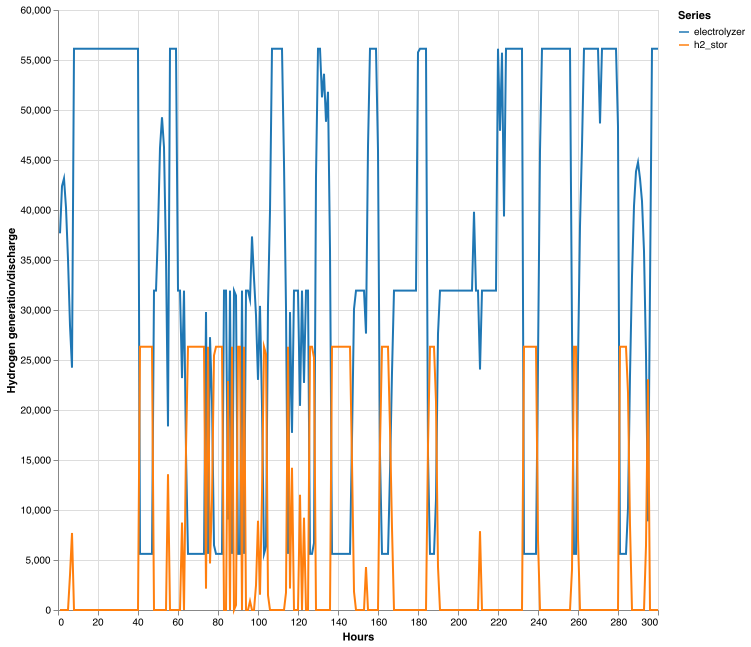

In [136]:
# plot = stack_h2_gen |> 
#     @vlplot(
#         mark={:area},
#         encoding={
#             x={:hours, title="Hours"},
#             y={:total, title="Hydrogen generation/discharge",stack=:zero},
#             color={:Series, scale={scheme=:category10}}
#         },
#         width=600,
#         height=600
#     )

plot = stack_h2_gen |> 
    @vlplot(
        mark={:line},
        encoding={
            x={:hours, title="Hours"},
            y={:Value, title="Hydrogen generation/discharge"},
            color={:Series, scale={scheme=:category10}}
        },
        width=600,
        height=600
    )


**Task 2:** using the asset definition in `naturalgas_power.json` as template, add a `naturalgas_hydrogen.json` asset representing Steam Methane Reforming for hydrogen production. This asset will be of type `ThermalHydrogen{NaturalGas}`, which is defined in `model/assets/thermalhydrogen.jl`

![smr](images/smr.png)


As transformation inputs, you can use:

    -emission_rate: 0.069029264,
    -efficiency_rate: 0.76865951,
    -electricity_consumption: 0.016404
                        
As hydrogen edge parameters, you can use:

    -existing_capacity: 0.0,
    -investment_cost": 29902.10236,
    -fixed_om_cost: 13685.61723,
    -variable_om_cost: 2.250837989,
    -capacity_size: 1082.95,
    -startup_cost: 0.126968004,
    -min_up_time: 3,
    -min_down_time: 3,
    -ramp_up_fraction: 0.5,
    -ramp_down_fraction: 0.5,
    -min_flow_fraction:0.85

<details>
<summary>Solution</summary>

</details>

**Task 3:** Re-load the input files (which now include the SMR) and define new MACRO model. Solve the model and compare results with those obtained above. What happens if you enforce a strict net-zero $\text{CO}_2$ cap by deleting the field `price_unmet_policy` from the $\text{CO}_2$ node in file `one_zone_multisector/system/nodes.json`?

<details>
<summary>Solution</summary>

</details>